Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. 

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook,nlp]
```

In [1]:
!pip install flaml[nlp,ray,notebook,optuna];
# from v0.6.6, catboost is made an optional dependency to build conda package.
# to install catboost without installing the notebook option, you can run:
# !pip install flaml[catboost]

## 2. Sentiment Classification Example
## Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas().iloc[0:10000]
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas().iloc[0:10000]
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [4]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [5]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [6]:
automl_settings = {
    "time_budget": 500,                                 # setting the time budget
    "task": "seq-classification",                       # specifying your task is seq-classification 
    "custom_hpo_args": {"output_dir": "data/output/", "ckpt_per_epoch": 1, "model_path": "google/electra-base-discriminator"},  # specifying your output directory
    "gpu_per_trial": 1,                                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",
    "log_type": "all",
    "n_concurrent_trials": 4,
    "max_iter": 8,
    "sample": False,
    "hpo_method": "optuna"                            
}

In [7]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=27674) {'eval_loss': 0.3430978059768677, 'eval_automl_metric': 0.0665137614678899, 'eval_runtime': 10.5616, 'eval_samples_per_second': 82.563, 'eval_steps_per_second': 82.563, 'epoch': 2.0}
(train pid=27662) {'eval_loss': 0.4666380286216736, 'eval_automl_metric': 0.0665137614678899, 'eval_runtime': 9.6845, 'eval_samples_per_second': 90.041, 'eval_steps_per_second': 90.041, 'epoch': 5.0}
(train pid=27667) {'eval_loss': 0.4148450493812561, 'eval_automl_metric': 0.06307339449541283, 'eval_runtime': 9.5869, 'eval_samples_per_second': 90.957, 'eval_steps_per_second': 90.957, 'epoch': 5.0}
(train pid=27667) {'eval_loss': 0.43206584453582764, 'eval_automl_metric': 0.06422018348623848, 'eval_runtime': 9.5331, 'eval_samples_per_second': 91.471, 'eval_steps_per_second': 91.471, 'epoch': 5.08}
(train pid=27662) {'eval_loss': 0.46918314695358276, 'eval_automl_metric': 0.06536697247706424, 'eval_runtime': 9.6084, 'eval_samples_per_second': 90.754, 'eval_steps_per_second': 90.754, 'epoch'

(train pid=27667) ***** Running Prediction *****
(train pid=27667)   Num examples = 872
(train pid=27667)   Batch size = 32
(train pid=27662) ***** Running Prediction *****
(train pid=27662)   Num examples = 872
(train pid=27662)   Batch size = 32


(train pid=27674) {'eval_loss': 0.37832382321357727, 'eval_automl_metric': 0.06766055045871555, 'eval_runtime': 11.0124, 'eval_samples_per_second': 79.184, 'eval_steps_per_second': 79.184, 'epoch': 2.31}
(train pid=27674) {'train_runtime': 498.5467, 'train_samples_per_second': 46.323, 'train_steps_per_second': 11.582, 'train_loss': 0.27595042092270783, 'epoch': 2.31}


(train pid=27674) ***** Running Prediction *****
(train pid=27674)   Num examples = 872
(train pid=27674)   Batch size = 32
2022-02-27 20:25:07,379	INFO tune.py:636 -- Total run time: 580.93 seconds (500.46 seconds for the tuning loop).
[flaml.automl: 02-27 20:25:09] {2763} INFO - selected model: None
[I 2022-02-27 20:25:09,404] A new study created in memory with name: optuna


(_trainable_function_wrapper pid=27621) E0227 20:25:10.462152096   31299 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


(_trainable_function_wrapper pid=27621) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_trainable_function_wrapper pid=27621)   warnings.warn(


(_trainable_function_wrapper pid=27621) {'loss': 0.3877, 'learning_rate': 7.632591149599169e-07, 'epoch': 0.66}


(_trainable_function_wrapper pid=27621) 2022-02-27 20:25:55,167	ERROR function_runner.py:268 -- Runner Thread raised error.
(_trainable_function_wrapper pid=27621) Traceback (most recent call last):
(_trainable_function_wrapper pid=27621)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/torch/serialization.py", line 379, in save
(_trainable_function_wrapper pid=27621)     _save(obj, opened_zipfile, pickle_module, pickle_protocol)
(_trainable_function_wrapper pid=27621)   File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/torch/serialization.py", line 499, in _save
(_trainable_function_wrapper pid=27621)     zip_file.write_record(name, storage.data_ptr(), num_bytes)
(_trainable_function_wrapper pid=27621) OSError: [Errno 28] No space left on device
(_trainable_function_wrapper pid=27621) 
(_trainable_function_wrapper pid=27621) During handling of the above exception, another exception occurred:
(_trainable_function_wrapper pid=27621) 
(_trai

2022-02-27 20:25:55,652	ERROR trial_runner.py:927 -- Trial _trainable_function_wrapper_69f64116: Error processing event.
Traceback (most recent call last):
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/trial_runner.py", line 893, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/tune/ray_trial_executor.py", line 707, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/ray/worker.py", line 1735, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
2022-02-27 20:25:55,664	WARNING worker.py:1257 -- A worker died or was killed while exec

The trial _trainable_function_wrapper_69f64116 errored with parameters={'learning_rate': 8.421292235057749e-05, 'num_train_epochs': 0.6593869048703147, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.19685216027373567, 'weight_decay': 0.16931560182347347, 'adam_epsilon': 9.840094059810994e-07, 'seed': 42, 'global_max_steps': 413, 'learner': 'transformer'}. Error file: /home/xliu127/ray_results/_trainable_function_wrapper_2022-02-27_20-25-09/_trainable_function_wrapper_69f64116_1_adam_epsilon=9.8401e-07,global_max_steps=413,learner=transformer,learning_rate=8.4213e-05,n_2022-02-27_20-25-09/error.txt


OSError: [Errno 28] No space left on device

### Best model and metric

In [ ]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: transformer
Best hyperparmeter config: {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}
Best accuracy on validation data: 0.9541
Training duration of best run: 75.44 s


In [ ]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [ ]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1821
  Batch size = 128


Predicted labels [1 0 0 ... 1 1 1]


### Log history

In [8]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 3.712265538348735e-06, 'num_train_epochs': 0.48393026940649086, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.16407075452197886, 'weight_decay': 0.23644850941274287, 'adam_epsilon': 4.4247296834481804e-07, 'seed': 44, 'global_max_steps': 152, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 3.712265538348735e-06, 'num_train_epochs': 0.48393026940649086, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.16407075452197886, 'weight_decay': 0.23644850941274287, 'adam_epsilon': 4.4247296834481804e-07, 'seed': 44, 'global_max_steps': 152, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 0.0005028960644627165, 'num_train_epochs': 0.39537091142700365, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.11233519789666767, 'weight_decay': 0.1235022

5


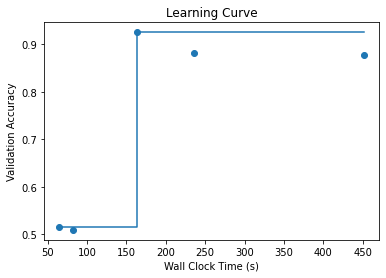

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Paraphrase Detection Example
### Load data and preprocess

The Microsoft Research Parallel Corpus (MRPC) is a dataset for paraphrase detection. An example pair of sentences is:

* sentence 1: Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
* sentence 2: Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .

First, let's load this dataset in to pandas dataframes: 

In [4]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "mrpc", split="train").to_pandas()
dev_dataset = load_dataset("glue", "mrpc", split="validation").to_pandas()
test_dataset = load_dataset("glue", "mrpc", split="test").to_pandas()


Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


The first 5 examples of this dataset:

In [ ]:
train_dataset.head(5)

,sentence1,sentence2,label,idx
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4


Separate the data into X and y:

In [7]:
custom_sent_keys = ["sentence1", "sentence2"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

KeyError: "None of [Index(['sentence'], dtype='object')] are in the [columns]"

### Run FLAML

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [5]:
automl_settings = {
    "time_budget": 300,                                 # setting the time budget
    "task": "seq-classification",                       # specifying your task is seq-classification 
    "custom_hpo_args": {"output_dir": "data/output/", "ckpt_per_epoch": 1, "model_path": "google/electra-base-discriminator"},  # specifying your output directory
    "gpu_per_trial": 1,                                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",                          
    "log_type": "all",
    "n_concurrent_trials": 4,
    "max_iter": 8,
    "sample": False
}


In [6]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

NameError: name 'X_train' is not defined

### Best model and metric

In [ ]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: transformer
Best hyperparmeter config: {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 69, 'FLAML_sample_size': 10000}
Best accuracy on validation data: 0.9553
Training duration of best run: 65.26 s


In [ ]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [ ]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]




### Log history

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}}


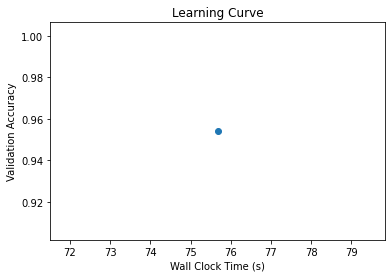

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()